In [ ]:
# setting for running at colab

!git clone https://<username>:<token>@gitlab.developers.cam.ac.uk/phy/data-intensive-science-mphil/assessments/a2_coursework/yi260.git
%cd yi260/main
! pwd

# MODULE 1: PET-CT Image Reconstruction

### Exercise 1.1: Clean up the sinograms.

In [1]:
import matplotlib.pyplot as plt

# Set default font sizes globally
plt.rcParams.update({
    'font.size': 12,            # Base font size
    'axes.titlesize': 14,       # Title font size
    'axes.labelsize': 12,       # X and Y axis label size
    'xtick.labelsize': 12,      # X-axis tick size
    'ytick.labelsize': 12,      # Y-axis tick size
    'legend.fontsize': 12       # Legend font size
})

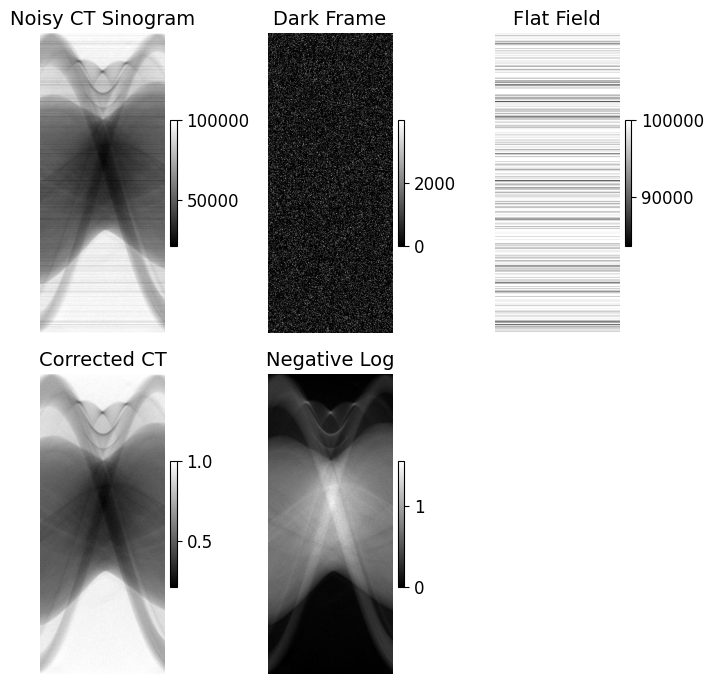

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
ct_sino = np.load("./Data/Module1/ct_sinogram.npy")
ct_dark = np.load("./Data/Module1/ct_dark.npy")
ct_flat = np.load("./Data/Module1/ct_flat.npy")

# Perform flat field correction & dark-frame subtraction
ct_corrected = (ct_sino - ct_dark) / (ct_flat - ct_dark)
ct_log = -np.log(ct_corrected)

# Set up figure
fig, axes = plt.subplots(2, 3, figsize=(7, 7))

# Helper function to display image with color bar
def show_image(ax, img, title):
    im = ax.imshow(img, cmap='gray', aspect='auto')
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot all images
show_image(axes[0, 0], ct_sino, "Noisy CT Sinogram")
show_image(axes[0, 1], ct_dark, "Dark Frame")
show_image(axes[0, 2], ct_flat, "Flat Field")
show_image(axes[1, 0], ct_corrected, "Corrected CT")
show_image(axes[1, 1], ct_log, "Negative Log")

# Hide last empty subplot (optional)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


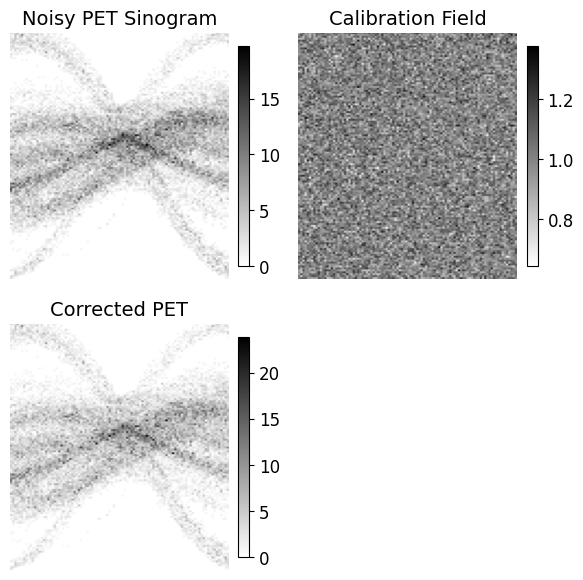

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
pet_sino = np.load("./Data/Module1/pet_sinogram.npy")
pet_cal = np.load("./Data/Module1/pet_calibration.npy")
pet_cal1 = (pet_sino / pet_cal) * np.mean(pet_cal)

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

def show_image(ax, img, title):
    im = ax.imshow(img, cmap='gray_r', aspect='auto')
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot images with colorbars
show_image(axes[0, 0], pet_sino, "Noisy PET Sinogram")
show_image(axes[0, 1], pet_cal, "Calibration Field")
show_image(axes[1, 0], pet_cal1, "Corrected PET")

# Hide the empty subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### Exercise 1.2:

Reconstruct the CT image with FBP and OS-SART

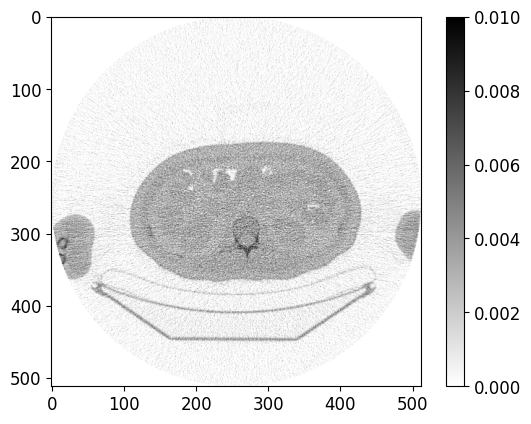

In [4]:
from skimage.transform import iradon
theta = np.linspace(0., 180.,180, endpoint=False)
ct_recon = iradon(ct_log, theta=theta)
plt.imshow(ct_recon,cmap="gray_r", vmin=0, vmax = 0.01)
plt.colorbar()


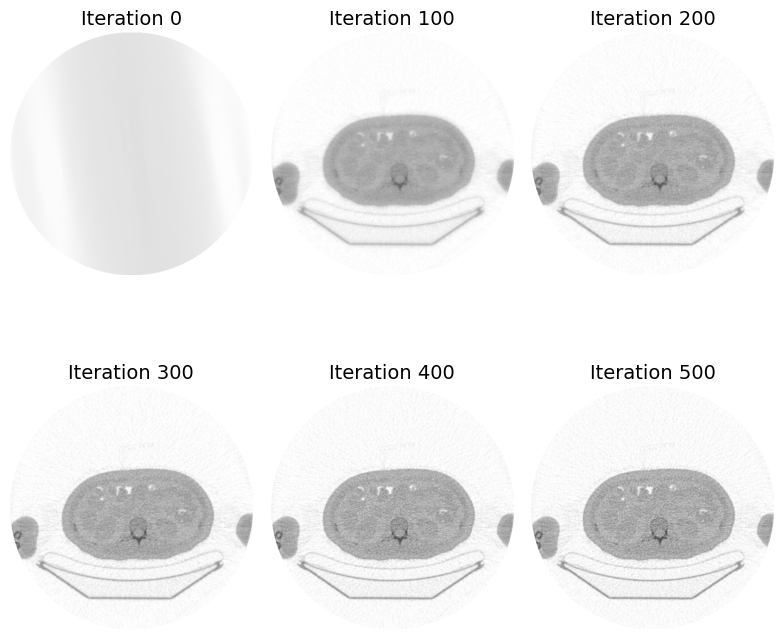

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon, radon

# Parameters
gamma = 0.001
max_iter = 501
num_chosen = 18

# Assuming `ct_recon`, `ct_corrected`, and `theta` are defined
x = np.zeros(ct_recon.shape)

# Adjust the number of plots to match `k % 50 == 0`
every_nth = 100
num_plots = max_iter // every_nth  # Should match the number of plotted frames

# Create subplots (5 columns)
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

# Flatten axes for easy 1D indexing
axes = axes.flatten()

def sliding_window(theta, num_chosen, iteration):
    start_idx = (iteration * num_chosen) % len(theta)
    indices = np.arange(start_idx, start_idx + num_chosen) % len(theta)
    chosen_elements = theta[indices]
    return chosen_elements, indices

for k in range(max_iter):
    theta_subset, subset_indices = sliding_window(theta, num_chosen, k)
    residual = ct_log[:, subset_indices] - radon(x, theta_subset)

    # Normalize gradient for stability
    gradient = gamma * iradon(residual, theta_subset, filter_name=None)
    x = x + gradient

    # Visualization every 10 steps
    if k % every_nth == 0:
        idx = k // every_nth
        axes[idx].imshow(x, cmap='gray_r', vmin=0, vmax = 0.01)            
        if k == 0: 
            axes[idx].set_title(f'Iteration 1') # zero-indexing is a bit confusing
        else:
            axes[idx].set_title(f'Iteration {k}')

        axes[idx].set_title(f'Iteration {k}')
        axes[idx].axis('off')
plt.tight_layout()
plt.show()


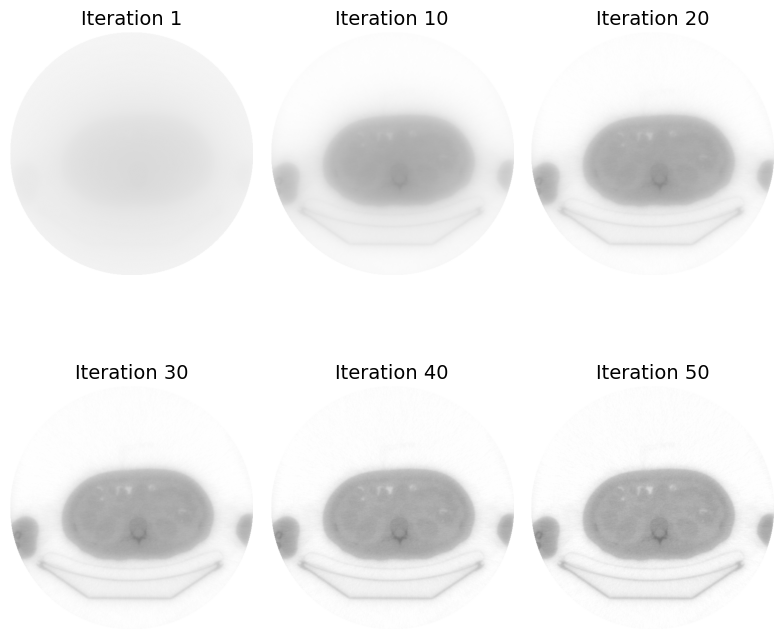

In [6]:
# Normal SART

# Parameters
gamma = 0.001
max_iter = 51
num_chosen = 180 # use all angles

# Assuming `ct_recon`, `ct_corrected`, and `theta` are defined
x = np.zeros(ct_recon.shape)

# Adjust the number of plots to match `k % 50 == 0`
every_nth = 10
num_plots = max_iter // every_nth  # Should match the number of plotted frames

# Create subplots (5 columns)
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

# Flatten axes for easy 1D indexing
axes = axes.flatten()

def sliding_window(theta, num_chosen, iteration):
    start_idx = (iteration * num_chosen) % len(theta)
    indices = np.arange(start_idx, start_idx + num_chosen) % len(theta)
    chosen_elements = theta[indices]
    return chosen_elements, indices

for k in range(max_iter):
    theta_subset, subset_indices = sliding_window(theta, num_chosen, k)
    residual = ct_log[:, subset_indices] - radon(x, theta_subset)

    # Normalize gradient for stability
    gradient = gamma * iradon(residual, theta_subset, filter_name=None)
    x = x + gradient

    # Visualization every 10 steps
    if k % every_nth == 0:
        idx = k // every_nth
        if idx < len(axes):  # Avoid out-of-bounds error
            axes[idx].imshow(x, cmap='gray_r', vmin=0, vmax = 0.01) 
            if k == 0: 
                axes[idx].set_title(f'Iteration 1') # zero-indexing is a bit confusing
            else:
                axes[idx].set_title(f'Iteration {k}')
            axes[idx].axis('off')
plt.tight_layout()
plt.show()


### Exercise 1.3: Attenuation correct

/home/yi260/.conda/envs/a2coursework/lib/python3.10/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


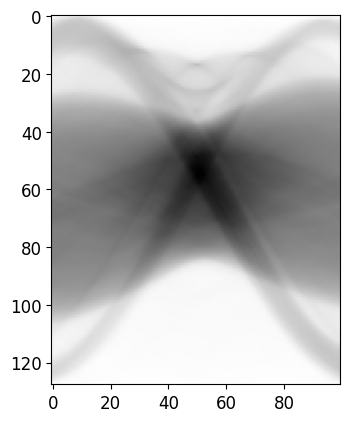

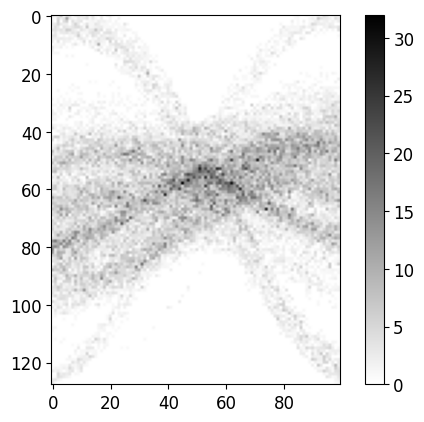

In [7]:
# lecture 2 p25

import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from skimage.transform import iradon, radon
# interpolate to 4 times the original resolution
upsampled_CT = zoom(x, zoom=1/4, order=3)

# radon transform to 100 different angles
theta_pet = np.linspace(0., 180.,100, endpoint=False)
ct_sino2 = radon(upsampled_CT, theta=theta_pet)
plt.imshow(ct_sino2,cmap="gray_r")

epsiron = 0.01
pet_cal2 = pet_cal1*np.exp(ct_sino2)
plt.figure()
plt.imshow(pet_cal2,cmap="gray_r")
plt.colorbar()

### 1.4: PET reconstruction

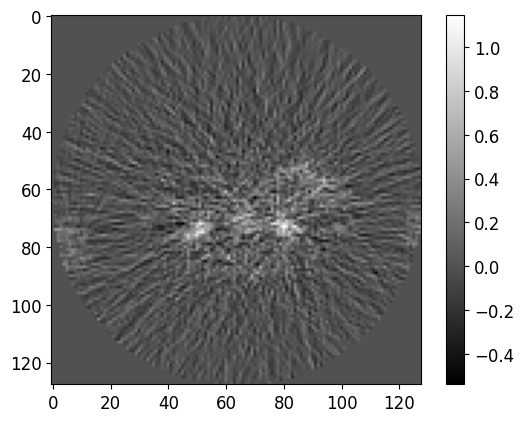

In [10]:
# using FBP
from skimage.transform import iradon
pet_recon_fbp = iradon(pet_cal2, theta=theta_pet)
plt.imshow(pet_recon_fbp,cmap="gray")
plt.colorbar()

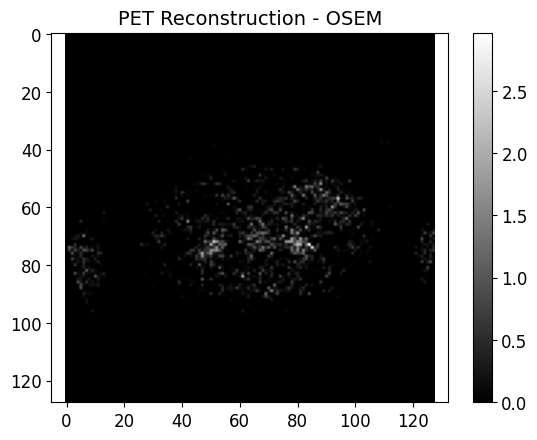

In [11]:
# 
num_subsets = 10
pet_recon_osem = np.ones_like(pet_recon_fbp)
iterations = 10

for _ in range(iterations):
    for i in range(num_subsets):
        subset_indices = np.arange(i, 100, num_subsets)
        if len(subset_indices) == 0:
            continue
        subset_sino = pet_cal2[:, subset_indices]
        subset_theta = theta_pet[subset_indices]
        forward_proj = radon(pet_recon_osem, theta=subset_theta)
        correction_factor = np.divide(subset_sino, forward_proj, out=np.ones_like(forward_proj), where=forward_proj!=0)
        backward_proj = iradon(correction_factor, theta=subset_theta, filter_name=None, interpolation='linear')
        pet_recon_osem *= backward_proj

plt.figure()
plt.imshow(pet_recon_osem, cmap="gray")
plt.axis("equal")
plt.title("PET Reconstruction - OSEM")
plt.colorbar()
plt.show()

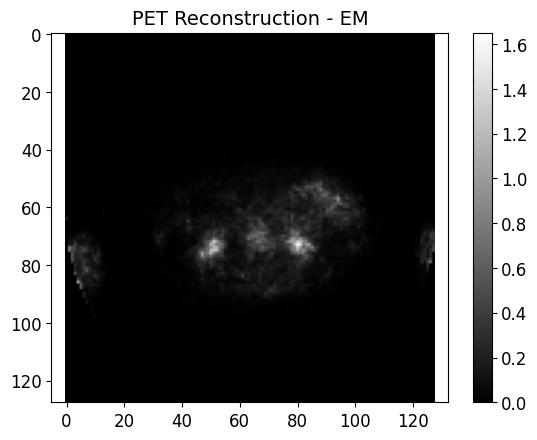

In [12]:
# Not using subsets
num_subsets = 1
pet_recon_em = np.ones_like(pet_recon_fbp)
iterations = 10

for _ in range(iterations):
    for i in range(num_subsets):
        subset_indices = np.arange(i, 100, num_subsets)
        if len(subset_indices) == 0:
            continue
        subset_sino = pet_cal2[:, subset_indices]
        subset_theta = theta_pet[subset_indices]
        forward_proj = radon(pet_recon_em, theta=subset_theta)
        correction_factor = np.divide(subset_sino, forward_proj, out=np.ones_like(forward_proj), where=forward_proj!=0)
        backward_proj = iradon(correction_factor, theta=subset_theta, filter_name=None, interpolation='linear')
        pet_recon_em *= backward_proj

plt.figure()
plt.imshow(pet_recon_em, cmap="gray")
plt.axis("equal")
plt.title("PET Reconstruction - EM")
plt.colorbar()
plt.show()

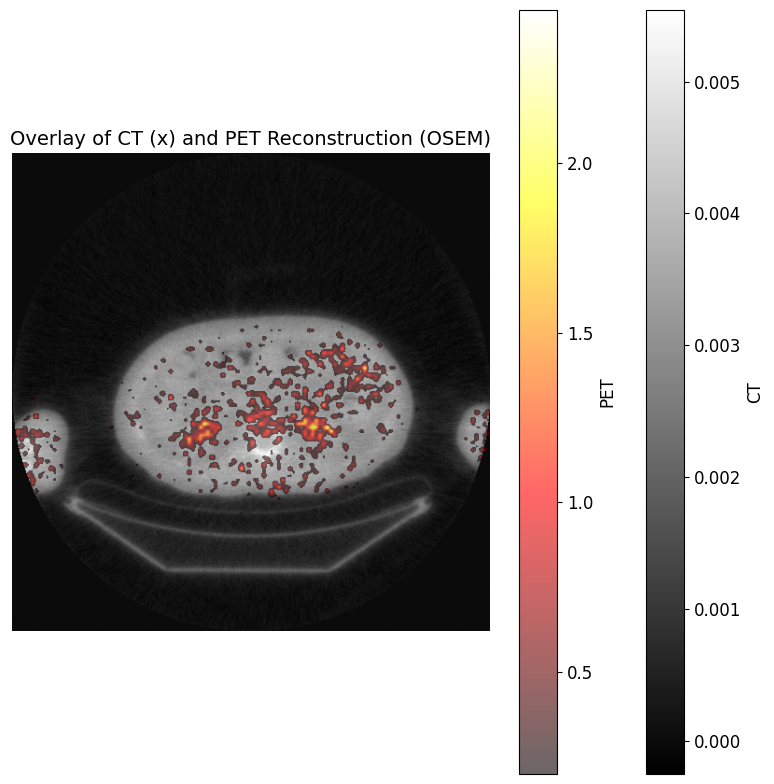

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Resize PET reconstruction to match x
pet_resized = resize(pet_recon_osem, x.shape, preserve_range=True, anti_aliasing=True)
masked_pet = np.where(pet_resized <= 0.2, np.nan, pet_resized)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

im1 = ax.imshow(x, cmap='gray')
cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label('CT')

im2 = ax.imshow(masked_pet, cmap='hot', alpha=0.6)
cbar2 = plt.colorbar(im2, ax=ax)
cbar2.set_label('PET')

ax.set_title("Overlay of CT (x) and PET Reconstruction (OSEM)")
ax.axis('off')
plt.tight_layout()
plt.show()
